In [96]:
import os
import pickle
import re

import gensim
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

from src.config import cfg
from src.data import anime_id_label_encoding, load_data, user_id_label_encoding
from src.seed import seed_everything

seed_everything(cfg.seed)
if os.path.basename(os.getcwd()) != "notebook":
    os.chdir("../")


https://www.guruguru.science/competitions/21/discussions/2f046ba3-88cc-4505-9362-60cd298f3014/

- LDA(Latent Dirichlet Allocation)によるユーザーとアニメのトピック抽出
- サイト上での実装はjapanese_nameに放送開始日を入れたものでトピックを生成していたが、本notebookではanime_idでトピックを生成する

In [89]:
train_df, test_df, anime_df = load_data()
train_test_df = pl.concat([train_df, test_df], how="diagonal")

train_test_df.head()


user_id,anime_id,score
str,str,i64
"""0008e10fb39e55447333""","""0669cc0219d468761195""",2
"""0008e10fb39e55447333""","""111adb8835b8a1a2cf54""",10
"""0008e10fb39e55447333""","""1fc8683c393432a2f9c7""",1
"""0008e10fb39e55447333""","""2290175205d55e81b197""",8
"""0008e10fb39e55447333""","""28f173b60331d5cabb0d""",9


In [3]:
# 辞書とコーパスの作成

# user毎に評価したアニメのコーパスを作成
user_item_df = train_test_df.group_by("user_id", maintain_order=True).agg(pl.col("anime_id"))

# 辞書の作成
dictionary = Dictionary(user_item_df["anime_id"].to_list())

# コーパスの作成
corpus = [dictionary.doc2bow(item) for item in user_item_df["anime_id"].to_list()]


100%|██████████| 13/13 [04:49<00:00, 22.28s/it]


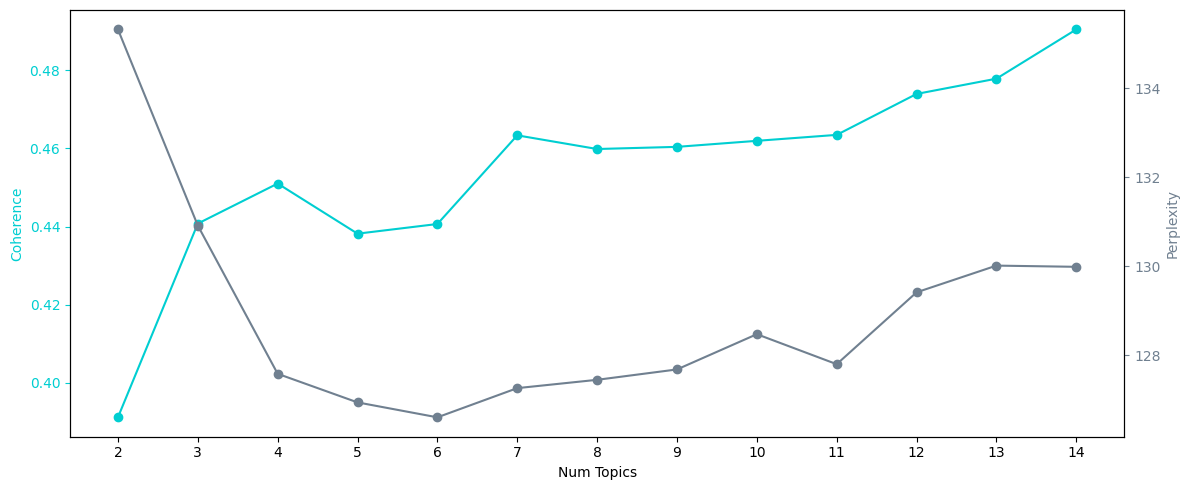

In [4]:
# トピック数の検討
start = 2
limit = 15
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=cfg.seed, iterations=200, passes=10
    )
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(
        model=lda_model, texts=user_item_df["anime_id"].to_list(), dictionary=dictionary, coherence="c_v"
    )
    coherence_vals.append(coherence_model_lda.get_coherence())

# 可視化
x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12, 5))

# coherence
c1 = "darkturquoise"
ax1.plot(x, coherence_vals, "o-", color=c1)
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Coherence", color=c1)
ax1.tick_params("y", colors=c1)

# perplexity
c2 = "slategray"
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, "o-", color=c2)
ax2.set_ylabel("Perplexity", color=c2)
ax2.tick_params("y", colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()


In [5]:
# 上記結果からトピック数を7としてLDAモデルの学習
num_topics = 7
lda_model = LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=cfg.seed, iterations=200, passes=10
)


In [67]:
# ユーザー毎の各トピックへの所属確率
topic_arr = np.zeros((len(corpus), num_topics))

for row, doc in enumerate(corpus):
    for l in lda_model.get_document_topics(doc):  # noqa: E741
        if len(l) > 0:
            topic_arr[row, l[0]] = l[1]

# DataFrameに変換
user_topic_df = pl.from_numpy(topic_arr, schema=[f"user_topic_{i}" for i in range(num_topics)])

# user_idを付与したDataFrameを作成
user_topic_feat_df = pl.concat([user_item_df, user_topic_df], how="horizontal").drop("anime_id")
user_topic_feat_df.head()


user_id,user_topic_0,user_topic_1,user_topic_2,user_topic_3,user_topic_4,user_topic_5,user_topic_6
str,f64,f64,f64,f64,f64,f64,f64
"""0008e10fb39e55447333""",0.0,0.726561,0.0,0.0,0.0,0.0,0.263053
"""001a7aed2546342e2602""",0.056528,0.0,0.441778,0.403243,0.0,0.096931,0.0
"""003d4b0257cc7849ffe1""",0.832633,0.0,0.0,0.0,0.0,0.0,0.155439
"""0054e700b5be6e074fb7""",0.011941,0.011925,0.011929,0.011933,0.011935,0.011959,0.928379
"""0059344eed7e8ca0b6c5""",0.0,0.0,0.0,0.513391,0.0,0.0,0.446847


In [88]:
# アニメ毎の各トピックへの所属確率
anime_topic_matrix = lda_model.get_topics()

anime_topics = {}
for anime_id, anime_index in dictionary.token2id.items():
    topic_dist = anime_topic_matrix[:, anime_index]
    # 割合にする
    anime_topics[anime_id] = topic_dist / topic_dist.sum()

# DataFrameに変換
anime_topic_feat_df = pl.DataFrame(anime_topics).transpose(
    include_header=True, header_name="anime_id", column_names=[f"anime_topic_{i}" for i in range(num_topics)]
)
anime_topic_feat_df.head()


anime_id,anime_topic_0,anime_topic_1,anime_topic_2,anime_topic_3,anime_topic_4,anime_topic_5,anime_topic_6
str,f32,f32,f32,f32,f32,f32,f32
"""04068820a73e52dc3b32""",0.015866,0.591739,0.214301,0.019232,0.015777,0.131956,0.011129
"""04a3d0b122b24965e909""",0.075085,0.116858,0.304779,0.106672,0.144859,0.016285,0.235462
"""0669cc0219d468761195""",0.011658,0.634649,0.218056,0.007917,0.009775,0.092372,0.025573
"""111adb8835b8a1a2cf54""",0.019309,0.393335,0.335446,0.008104,0.022024,0.206176,0.015605
"""1447fe1f10b59912d6a8""",0.276699,0.043991,0.137416,0.011828,0.028863,0.107545,0.393659


In [90]:
# ユーザー＆アニメトピック特徴量を追加
train_df = train_df.join(user_topic_feat_df, on="user_id", how="left")
train_df = train_df.join(anime_topic_feat_df, on="anime_id", how="left")
test_df = test_df.join(user_topic_feat_df, on="user_id", how="left")
test_df = test_df.join(anime_topic_feat_df, on="anime_id", how="left")


user_id,anime_id,user_topic_0,user_topic_1,user_topic_2,user_topic_3,user_topic_4,user_topic_5,user_topic_6,anime_topic_0,anime_topic_1,anime_topic_2,anime_topic_3,anime_topic_4,anime_topic_5,anime_topic_6
str,str,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32
"""0008e10fb39e55447333""","""04068820a73e52dc3b32""",0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.015866,0.591739,0.214301,0.019232,0.015777,0.131956,0.011129
"""0008e10fb39e55447333""","""04a3d0b122b24965e909""",0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.075085,0.116858,0.304779,0.106672,0.144859,0.016285,0.235462
"""0008e10fb39e55447333""","""1447fe1f10b59912d6a8""",0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.276699,0.043991,0.137416,0.011828,0.028863,0.107545,0.393659
"""0008e10fb39e55447333""","""2622632598c68682afd5""",0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.057713,0.203787,0.197613,0.057586,0.225478,0.018197,0.239626
"""0008e10fb39e55447333""","""2701850c7216516fec46""",0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.108245,0.246264,0.099755,0.177891,0.257222,0.0921,0.018522


In [97]:
# ラベルエンコード
train_df, test_df = user_id_label_encoding(train_df, test_df)
train_df, test_df, anime_df = anime_id_label_encoding(train_df, test_df, anime_df)


user_id,anime_id,user_topic_0,user_topic_1,user_topic_2,user_topic_3,user_topic_4,user_topic_5,user_topic_6,anime_topic_0,anime_topic_1,anime_topic_2,anime_topic_3,anime_topic_4,anime_topic_5,anime_topic_6
i64,i64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32
0,27,0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.015866,0.591739,0.214301,0.019232,0.015777,0.131956,0.011129
0,34,0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.075085,0.116858,0.304779,0.106672,0.144859,0.016285,0.235462
0,152,0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.276699,0.043991,0.137416,0.011828,0.028863,0.107545,0.393659
0,297,0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.057713,0.203787,0.197613,0.057586,0.225478,0.018197,0.239626
0,303,0.0,0.726561,0.0,0.0,0.0,0.0,0.263053,0.108245,0.246264,0.099755,0.177891,0.257222,0.0921,0.018522


In [98]:
# 学習 → sub

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

# Create a column for the fold number
train_df = train_df.with_columns(pl.lit(-1).alias("fold"))

# Assign the fold number to each row
for fold, (_, val_index) in enumerate(skf.split(train_df, train_df["score"])):
    train_df[val_index, "fold"] = fold

# Training and evaluation with LightGBM
scores_lgb = []
models_lgb = []
feature_importances = []

for fold in range(cfg.n_splits):
    print(f"Training for fold {fold}...")

    # Prepare the train and validation data
    train_data = train_df.filter(pl.col("fold") != fold)
    val_data = train_df.filter(pl.col("fold") == fold)

    # Define the features and the target
    features = test_df.columns
    target = "score"

    # Prepare the LightGBM datasets
    lgb_train = lgb.Dataset(train_data[features].to_pandas(), train_data[target].to_pandas())
    lgb_val = lgb.Dataset(val_data[features].to_pandas(), val_data[target].to_pandas())

    # Train the model
    callbacks = [
        lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
        lgb.log_evaluation(period=cfg.lgb.log_evaluation_period),
    ]
    model_lgb = lgb.train(
        dict(cfg.lgb.params),
        lgb_train,
        valid_sets=[lgb_val],
        callbacks=callbacks,
        num_boost_round=cfg.lgb.num_boost_round,
    )

    # Save the model
    with open(f"model_lgb_{fold}.pkl", "wb") as f:
        pickle.dump(model_lgb, f)

    # Predict the validation data
    val_pred_lgb = model_lgb.predict(val_data[features].to_pandas(), num_iteration=model_lgb.best_iteration)

    # Evaluate the model
    score_lgb = np.sqrt(mean_squared_error(val_data[target].to_pandas(), val_pred_lgb))
    scores_lgb.append(score_lgb)

    print(f"RMSE for fold {fold}: {score_lgb}")

    # Save feature importances
    feature_importances.append(model_lgb.feature_importance(importance_type="gain"))

# Calculate the average score
average_score_lgb = np.mean(scores_lgb)

print(f"Average RMSE: {average_score_lgb}")

# Calculate the average feature importance
average_feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({"feature": features, "importance": average_feature_importance}).sort_values(
    by="importance", ascending=False
)

print("Feature Importances:")
print(feature_importance_df)

# Predict the test data and create the submission file
submission_df = pl.read_csv(cfg.data.sample_submission_path, try_parse_dates=True)
submission_df = submission_df.with_columns(pl.lit(0).alias("score"))

for fold in range(cfg.n_splits):
    with open(f"model_lgb_{fold}.pkl", "rb") as f:
        model_lgb = pickle.load(f)
    test_pred_lgb = model_lgb.predict(test_df[features].to_pandas(), num_iteration=model_lgb.best_iteration)
    submission_df = submission_df.with_columns(
        (pl.col("score") + pl.Series(test_pred_lgb) / cfg.n_splits).alias("score")
    )

submission_df.write_csv(cfg.data.output_path + "submission_baseline_lda.csv")


Training for fold 0...
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 1.47399
[200]	valid_0's rmse: 1.43304
[300]	valid_0's rmse: 1.40091
[400]	valid_0's rmse: 1.3753
[500]	valid_0's rmse: 1.35605
[600]	valid_0's rmse: 1.34151
[700]	valid_0's rmse: 1.33001
[800]	valid_0's rmse: 1.32032
[900]	valid_0's rmse: 1.31171
[1000]	valid_0's rmse: 1.30442
[1100]	valid_0's rmse: 1.29745
[1200]	valid_0's rmse: 1.29142
[1300]	valid_0's rmse: 1.28557
[1400]	valid_0's rmse: 1.28088
[1500]	valid_0's rmse: 1.27668
[1600]	valid_0's rmse: 1.27268
[1700]	valid_0's rmse: 1.2687
[1800]	valid_0's rmse: 1.26519
[1900]	valid_0's rmse: 1.2619
[2000]	valid_0's rmse: 1.25868
[2100]	valid_0's rmse: 1.25576
[2200]	valid_0's rmse: 1.25305
[2300]	valid_0's rmse: 1.25042
[2400]	valid_0's rmse: 1.24786
[2500]	valid_0's rmse: 1.24513
[2600]	valid_0's rmse: 1.2426
[2700]	valid_0's rmse: 1.24027
[2800]	valid_0's rmse: 1.23837
[2900]	valid_0's rmse: 1.23655
[3000]	valid_0's rmse: 1.2347